# Logistic Regression
A detailed but practical description of logistic regresion can be found [here](http://ml-cheatsheet.readthedocs.io/en/latest/logistic_regression.html)
This notebook will focus on:

* Simple logistic regression
* Logistic regression with undersample

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
np.random.seed(42)

In [2]:
# Prints the metrics that we're going to use to evaluate classifier performance.
def my_test_results(model, X, Y):
    confmx = confusion_matrix((Y == 1),
                              (model.predict(X) > 0.5), labels=[0, 1])
    accuracy = (confmx[0, 0] + confmx[1, 1]) / sum(sum(confmx))
    precision = float(confmx[1, 1] / (confmx[1, 1]+confmx[0, 1]))
    recall = float(confmx[1, 1] / (confmx[1, 1]+confmx[1, 0]))
    f1 = (2.0*precision*recall)/(precision+recall)
    print("Out of sample accuracy = %4.3f" % accuracy)
    print("Out of sample precision = %4.3f" % precision)
    print("Out of sample recall = %4.3f" % recall)
    print("Out of sample F1 = %4.3f" % f1)

    ax = plt.subplot()
    sns.heatmap(confmx, annot=True, ax=ax, fmt='g')

    # labels, title and ticks
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix')
    ax.xaxis.set_ticklabels(['Not Fraud', 'Fraud'])
    ax.yaxis.set_ticklabels(['Not Fraud', 'Fraud'])

### Import Data

* Load data
* Remove useless columns and records (only CASH_OUT and TRANSFER have fraud).
* Remap transfer to 0/1.

In [3]:
df = pd.read_csv('../simulated_transactions.csv.xz')
print(df.shape)
df.head()

(1305514, 11)


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,2,PAYMENT,18211.33,C1099717276,88.00,0.00,M417557780,0.00,0.00,0,0
1,2,CASH_IN,93240.07,C1350751778,47.00,93287.07,C665576141,12.00,8650239.39,0,0
2,2,CASH_IN,78314.86,C332699949,93287.07,171601.93,C1359044626,178957.00,16435074.66,0,0
3,2,CASH_IN,101282.39,C808417649,171601.93,171601.93,C1599771323,171601.93,3771328.56,0,0
4,2,CASH_IN,24227.29,C858204589,171601.93,195829.22,C353842779,524999.00,872623.24,0,0


### Filtering
Filter out types other than TRANSFER, and CASH_OUT.<br>
Remove variables, 'step', 'nameOrig', 'nameDest', and 'isFlaggedFraud'.

In [4]:
df_filtered = df.drop(['step', 'nameOrig', 'nameDest', 'isFlaggedFraud'],
                      axis=1).query('type == "CASH_OUT" or type == "TRANSFER"')
df_filtered.loc[df_filtered.type == 'TRANSFER', 'type'] = 0
df_filtered.loc[df_filtered.type == 'CASH_OUT', 'type'] = 1
print(df_filtered.shape)

(586965, 7)


## Logistic Regression
Begin preparing for logistic regression

### Training Set
Partition the data with an 80/20 split: Training/Testing. <br>
Separate out the dependent variable from the independent variables.

In [5]:
train, test = train_test_split(df_filtered, test_size=0.2,
                               stratify=df_filtered['isFraud'])

Y_train = train['isFraud']
X_train = train.drop(['isFraud'], axis=1)

Y_test = test['isFraud']
X_test = test.drop(['isFraud'], axis=1)

### Simple Logistic Regression
Mindlessly plug data into logistic regression (Note that sklearn uses l2 cost function by default. Different packages may do this and, therefore, produce very different results).

Out of sample accuracy = 0.999
Out of sample precision = 0.964
Out of sample recall = 0.965
Out of sample F1 = 0.964


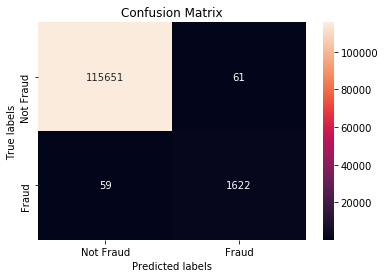

In [6]:
lm = linear_model.LogisticRegression()
lm = lm.fit(X_train, Y_train)
my_test_results(lm, X_test, Y_test)

* Accuracy - Proportion of predictions that are correct. $\frac{True Positive + True Negative}{True Positive + True Negative + False Positive + False Negative}$
* Precision - True positive over total positive actual cases. $\frac{True Positive}{True Positive + False Positive}$
* Recall - True positive over total positive predicted cases. $\frac{True Positive}{True Positive + False Negative}$
* F1 - A balance between Precision and Recall (harmonic mean of precision and recall) $\frac{2 * Precision * Recall}{Precision + Recall}$

### Results
In this case a simple logistic regression worked very well. The problem lacked great complexity and there are few independent variables. For problems like this, a logistic regression can work well.

### Logistic regression undersampling
When working with rare events like fraud, it's often best to undersample the negative cases.<br>
* Model training uses far fewer records so it can build much more quickly.
* Depending on the algorithm the model parameters, it may predicting 100% negative cases. This is becaues a rare event a model could be over 99% accurate by predicting nothing is fraud.<br>

In [7]:
training_count = len(Y_train)
fraud_count = len(Y_train[Y_train == 1])
non_fraud_indices = X_train[Y_train == 0].index
random_indices = np.random.choice(non_fraud_indices,
                                  10 * fraud_count, replace=False)
fraud_indices = X_train[Y_train == 1].index
under_sample_indices = np.concatenate([fraud_indices, random_indices])
under_sample = X_train.loc[under_sample_indices]
X_train_us = under_sample
Y_train_us = Y_train[under_sample_indices]

Out of sample accuracy = 0.999
Out of sample precision = 0.970
Out of sample recall = 0.938
Out of sample F1 = 0.954


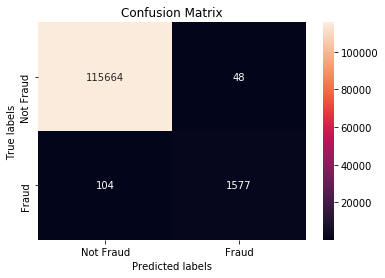

In [8]:
pos_weight = 5 * fraud_count / training_count
lm = linear_model.LogisticRegression(class_weight={1: pos_weight})
lm = lm.fit(X_train_us, Y_train_us)
my_test_results(lm, X_test, Y_test)

The model has similar results to the above, but trains more quickly. With very large datasets this can have a huge effect on training times<br>
In general, logistic regression does not perform as well as many other classifiers. e.g., Neural Nets, Random Forests, etc. Logistic regressions are fast and easy to make, interpret, and deploy.<br>
In this case, the model is a short equation with the following coefficients.
$P(fraud) = \frac{\exp(\beta_{0} + \beta_{1} \text{type} + \beta_{2} \text{amount} 
+ \beta_{3} \text{oldbalanceOrg} + \beta_{4} \text{newbalanceOrig} 
+ \beta_{5} \text{oldbalanceDest} + \beta_{6} \text{newbalanceDest}}
  {1 + \exp(\beta_{0} + \beta_{1} \text{type} + \beta_{2} \text{amount} 
+ \beta_{3} \text{oldbalanceOrg} + \beta_{4} \text{newbalanceOrig} 
+ \beta_{5} \text{oldbalanceDest} + \beta_{6} \text{newbalanceDest}}$